In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('/home/shreyasc/bliss')

In [9]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate
import healpy as hp
import math
import pathlib

import numpy as np
import pandas as pd
import torch
from astropy.io import fits
from astropy.io.fits import Header
from astropy.wcs import WCS
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from tqdm import trange
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.colors import LinearSegmentedColormap
from bliss.surveys.dc2 import read_frame_for_band
import pickle

In [7]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
#with initialize(config_path=".", version_base=None):

In [8]:
# step 1: get a list of images and extract their ra/dec bounds

In [4]:
data_dir = "/data/scratch/dc2local/run2.2i-dr6-v4/coadd-t3828-t3829/deepCoadd-results/"
image_lim = [4000, 4000]

In [ ]:
#NOTE: AFTER THIS CELL, SKIP TO THE LOADING PICKLE FILES CELL IF YOU DON'T NEED TO REGENERATE THE FULL DATA (MOST CASES)

In [5]:
BANDS = ("g", "i", "r", "u", "y", "z")

In [6]:
# extracted method from DC2 class, identical but provides minimal required functionality
def load_image_and_bg_files_list(bands, data_dir):
        img_pattern = "**/*/calexp*.fits"
        bg_pattern = "**/*/bkgd*.fits"
        image_files = []
        bg_files = []

        for band in bands:
            band_path = data_dir + str(band)
            img_file_list = list(pathlib.Path(band_path).glob(img_pattern))
            bg_file_list = list(pathlib.Path(band_path).glob(bg_pattern))

            image_files.append(sorted(img_file_list))
            bg_files.append(sorted(bg_file_list))
        n_image = len(bg_files[0])

        return n_image, image_files, bg_files

In [7]:
n_image, image_files, bg_files = load_image_and_bg_files_list(BANDS, data_dir)

In [14]:
image_lists = []
bg_lists = []
wcs_lists = []
for img_idx in trange(n_image):
    imlist, bglist, wcs = read_frame_for_band(image_files, bg_files, img_idx, len(BANDS), image_lim)
    image_lists.append(imlist)
    bg_lists.append(bglist)
    wcs_lists.append(WCS(Header.fromstring(wcs)))

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [06:43<00:00,  4.12s/it]


In [15]:
# now we can load the catalog
catalog = pd.read_csv("/data/scratch/shreyasc/cosmo_only.csv")

In [16]:
catalog

Unnamed: 0   shear_2         ra   galaxy_id   shear_1        dec  \
0                   0 -0.000170  54.842534  4937506723  0.000257 -34.218308   
1                   1 -0.000655  54.843331  4937521584  0.000011 -34.218300   
2                   2 -0.001352  54.852853  4937533577  0.000063 -34.217195   
3                   3 -0.004100  54.847085  4937618301 -0.000693 -34.216829   
4                   4 -0.003891  54.852781  4937638954 -0.000105 -34.215081   
...               ...       ...        ...         ...       ...        ...   
128290247   128290247  0.004900  61.153187  8833313718  0.000328 -38.479955   
128290248   128290248 -0.030293  59.693886  8833313719 -0.000678 -38.413741   
128290249   128290249  0.017399  61.133562  8833313723 -0.014894 -38.401485   
128290250   128290250  0.008090  59.315926  8833313726 -0.003475 -38.432946   
128290251   128290251  0.002583  59.557227  8833313727 -0.001535 -38.639698   

           convergence  
0            -0.000377  
1            -0.001224  
2            -0.001072  
3            -0.001797  
4            -0.001846  
...                ...  
128290247    -0.014087  
128290248    -0.010753  
128290249    -0.008421  
128290250     0.051260  
128290251    -0.048932  

[128290252 rows x 7 columns]

In [17]:
img_ids = []
shear_1s = []
shear_2s = []
plocss = []

# respective location to the first image (our "absolute location") to put maps in perspective
respective_im_0_plocss = []
wcs_0 = wcs_lists[0]

ra = torch.tensor(catalog["ra"].values).numpy().squeeze()
dec = torch.tensor(catalog["dec"].values).numpy().squeeze()

shear_1 = torch.tensor(catalog["shear_1"].values)
shear_2 = torch.tensor(catalog["shear_2"].values)
for imidx in trange(len(wcs_lists)):
    wcs = wcs_lists[imidx]
    img_list = image_lists[imidx]
    plocs_lim = img_list[0].shape
    height = plocs_lim[0]
    width = plocs_lim[1]
    pt, pr = wcs.all_world2pix(ra, dec, 0)  # convert to pixel coordinates
    plocs = torch.stack((torch.tensor(pr), torch.tensor(pt)), dim=-1)

    plocs = (plocs.reshape(1, plocs.size()[0], 2))[0]

    respective_im_0_pt, respective_im_0_pr = wcs_0.all_world2pix(ra, dec, 0)
    respective_im_0_plocs = torch.stack((torch.tensor(respective_im_0_pr), torch.tensor(respective_im_0_pt)), dim=-1)
    respective_im_0_plocs = (respective_im_0_plocs.reshape(1, respective_im_0_plocs.size()[0], 2))[0]
    
    # mask for current patch
    x0_mask = (plocs[:, 0] > 0) & (plocs[:, 0] < width)
    x1_mask = (plocs[:, 1] > 0) & (plocs[:, 1] < height)
    x_mask = x0_mask * x1_mask
    
    shear_1s.append(shear_1[x_mask])
    shear_2s.append(shear_2[x_mask])
    plocss.append(plocs[x_mask])
    respective_im_0_plocss.append(respective_im_0_plocs[x_mask])

100%|██████████| 98/98 [1:44:35<00:00, 64.03s/it]


In [ ]:
# save image_lists, shear1, shear2, plocs, im0plocs

In [40]:

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/image_lists.pkl", "wb") as f:
    pickle.dump(image_lists, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_1.pkl", "wb") as f:
    pickle.dump(shear_1s, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_2.pkl", "wb") as f:
    pickle.dump(shear_2s, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/plocs.pkl", "wb") as f:
    pickle.dump(plocss, f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/im0_plocs.pkl", "wb") as f:
    pickle.dump(respective_im_0_plocss, f)

In [10]:
with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/image_lists.pkl", "rb") as f:
    image_lists = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_1.pkl", "rb") as f:
    shear_1s = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/shear_2.pkl", "rb") as f:
    shear_2s = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/plocs.pkl", "rb") as f:
    plocss = pickle.load(f)

with open("/nfs/turbo/lsa-regier/scratch/shreyasc/dc2_lensing_eda/im0_plocs.pkl", "rb") as f:
    respective_im_0_plocss = pickle.load(f)

In [13]:
# TODO: verify not much variation in smaller grid
# for tenpix_x in range(0, 4000, 10):
#     for tenpix_y in range(0, 4000, 10):
#       take average and SD, find min / max / spread of SD (variance?)

In [11]:
num_shears = [len(shear_1) for shear_1 in shear_1s]
print("Mean shear data points per image: ", np.mean(num_shears))
print("Standard dev shear data points per image: ", np.std(num_shears))
print("Maximum shears:", max(num_shears))
print("Minimum shears:", min(num_shears))

Mean shear data points per image:  223716.98979591837
Standard dev shear data points per image:  42295.0911033263
Maximum shears: 264491
Minimum shears: 152791


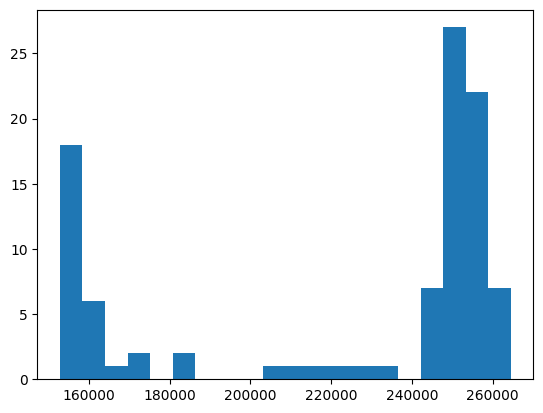

In [14]:
# Definitely not normally distributed...
n, bins, patches = plt.hist(num_shears, bins=20)
plt.show()

In [18]:
def plot_single_shear_map(idx, grid_size, original_size, shear_type):
    # testing with first 10 images
    image_list, s1, s2, ploc = image_lists[idx], shear_1s[idx], shear_2s[idx], plocss[idx]
    image = np.stack(image_list) # for printing image
    image = np.sum(image, axis=0)
    vmin = image.min().item()
    vmax = image.max().item()

    # Create a grid to represent the shear field
    shear_grid = np.zeros(grid_size)  # Initialize grid with zeros

    # Assign shear values to the corresponding grid cells
    if shear_type == "Horizontal Shear":
        shear_og = s1
    elif shear_type == "Diagonal Shear":
        shear_og = s2
    else:
        print("Unknown shear type: ", shear_type, " not in {'Horizontal Shear', 'Diagonal Shear'}")
    for inner_idx, (pixel1, pixel2) in enumerate(ploc):
        # TODO: replace the below with an accumulator (torch.gather or torch.scatter(?)) since currently it replaces
        i = int((pixel1 / float(original_size[0])) * (grid_size[0] - 1))  # Scale pixel coordinate to fit the grid
        j = int((pixel2 / float(original_size[1])) * (grid_size[1] - 1))  # Scale pixel coordinate to fit the grid
        shear_grid[i, j] = shear_og[inner_idx]

    print("X: ", torch.min(respective_im_0_plocss[idx][:,0]), torch.max(respective_im_0_plocss[idx][:,0]), "Y: ", torch.min(respective_im_0_plocss[idx][:,1]), torch.max(respective_im_0_plocss[idx][:,1]))
    # todo make zeros black

    plt.imshow(shear_grid, cmap="coolwarm", extent=(0, original_size[0], 0, original_size[1]))
    plt.colorbar(label=shear_type)
    plt.title(shear_type)
    plt.grid(True)
    plt.show()

X:  tensor(0.0461, dtype=torch.float64) tensor(3999.9833, dtype=torch.float64) Y:  tensor(0.0164, dtype=torch.float64) tensor(3999.9655, dtype=torch.float64)


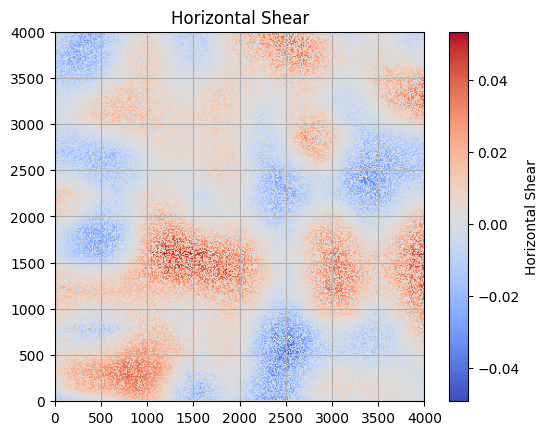

X:  tensor(3900.0087, dtype=torch.float64) tensor(7899.9921, dtype=torch.float64) Y:  tensor(0.0070, dtype=torch.float64) tensor(3999.9889, dtype=torch.float64)


X:  tensor(7900.0022, dtype=torch.float64) tensor(11899.9841, dtype=torch.float64) Y:  tensor(0.0110, dtype=torch.float64) tensor(3999.9785, dtype=torch.float64)


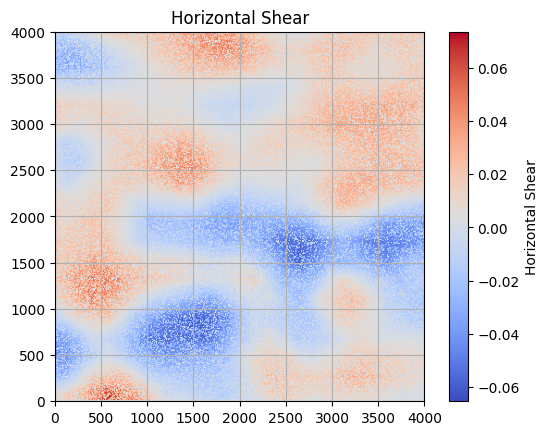

X:  tensor(11900.0324, dtype=torch.float64) tensor(15899.9972, dtype=torch.float64) Y:  tensor(0.0035, dtype=torch.float64) tensor(3999.9828, dtype=torch.float64)


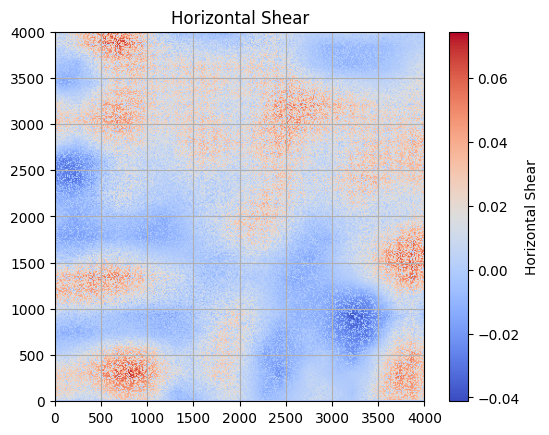

X:  tensor(15900.0191, dtype=torch.float64) tensor(19899.9711, dtype=torch.float64) Y:  tensor(0.0167, dtype=torch.float64) tensor(3999.9830, dtype=torch.float64)


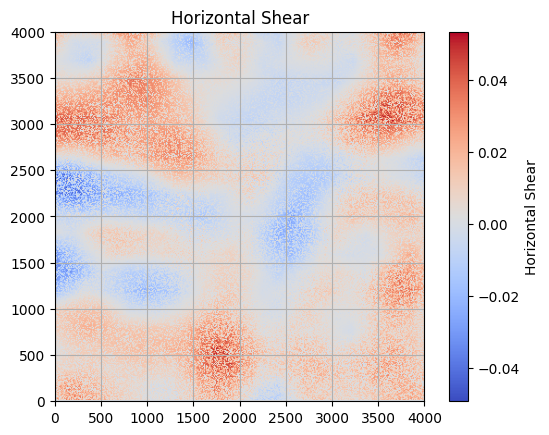

X:  tensor(19900.0214, dtype=torch.float64) tensor(23899.9797, dtype=torch.float64) Y:  tensor(0.0114, dtype=torch.float64) tensor(3999.9981, dtype=torch.float64)


X:  tensor(23900.0020, dtype=torch.float64) tensor(27899.9981, dtype=torch.float64) Y:  tensor(0.0210, dtype=torch.float64) tensor(3999.9777, dtype=torch.float64)


X:  tensor(0.0049, dtype=torch.float64) tensor(3999.9711, dtype=torch.float64) Y:  tensor(3900.0312, dtype=torch.float64) tensor(7899.9828, dtype=torch.float64)


X:  tensor(3900.0500, dtype=torch.float64) tensor(7899.9944, dtype=torch.float64) Y:  tensor(3900.0501, dtype=torch.float64) tensor(7899.9410, dtype=torch.float64)


X:  tensor(7900.0038, dtype=torch.float64) tensor(11899.9880, dtype=torch.float64) Y:  tensor(3900.0032, dtype=torch.float64) tensor(7899.9406, dtype=torch.float64)


In [16]:
# scale is 10 pixels : 1 point on graph (as defined below)
grid_size = (400, 400)  # Define the size of the grid
original_size = (4000, 4000)
shear_type = "Horizontal Shear"
for idx in range(10): #98 patches in total, this is just the first 10
    plot_single_shear_map(idx, grid_size, original_size, shear_type)

X:  tensor(0.0461, dtype=torch.float64) tensor(3999.9833, dtype=torch.float64) Y:  tensor(0.0164, dtype=torch.float64) tensor(3999.9655, dtype=torch.float64)


X:  tensor(3900.0087, dtype=torch.float64) tensor(7899.9921, dtype=torch.float64) Y:  tensor(0.0070, dtype=torch.float64) tensor(3999.9889, dtype=torch.float64)


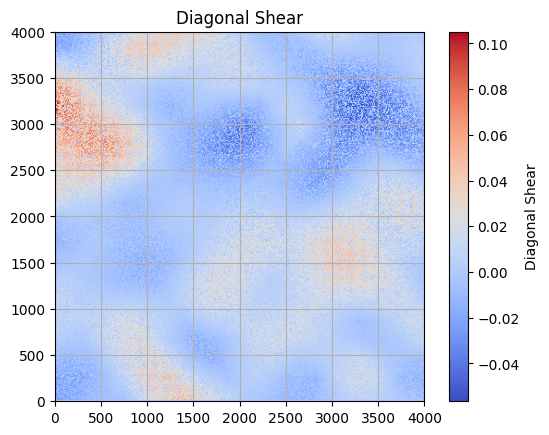

X:  tensor(7900.0022, dtype=torch.float64) tensor(11899.9841, dtype=torch.float64) Y:  tensor(0.0110, dtype=torch.float64) tensor(3999.9785, dtype=torch.float64)


X:  tensor(11900.0324, dtype=torch.float64) tensor(15899.9972, dtype=torch.float64) Y:  tensor(0.0035, dtype=torch.float64) tensor(3999.9828, dtype=torch.float64)


X:  tensor(15900.0191, dtype=torch.float64) tensor(19899.9711, dtype=torch.float64) Y:  tensor(0.0167, dtype=torch.float64) tensor(3999.9830, dtype=torch.float64)


X:  tensor(19900.0214, dtype=torch.float64) tensor(23899.9797, dtype=torch.float64) Y:  tensor(0.0114, dtype=torch.float64) tensor(3999.9981, dtype=torch.float64)


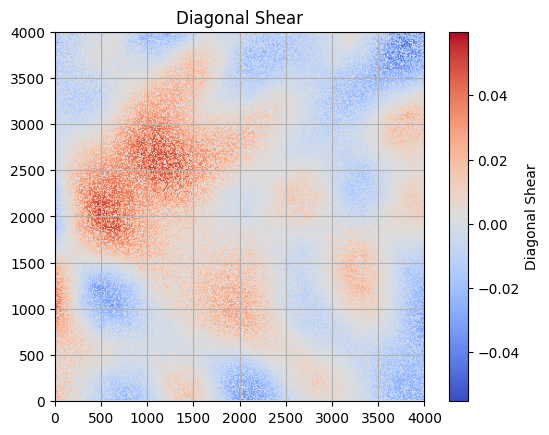

X:  tensor(23900.0020, dtype=torch.float64) tensor(27899.9981, dtype=torch.float64) Y:  tensor(0.0210, dtype=torch.float64) tensor(3999.9777, dtype=torch.float64)


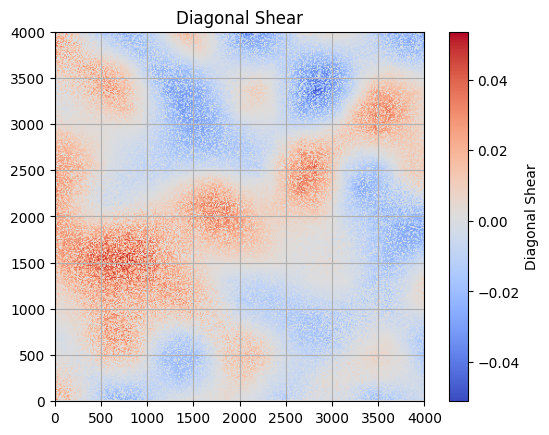

X:  tensor(0.0049, dtype=torch.float64) tensor(3999.9711, dtype=torch.float64) Y:  tensor(3900.0312, dtype=torch.float64) tensor(7899.9828, dtype=torch.float64)


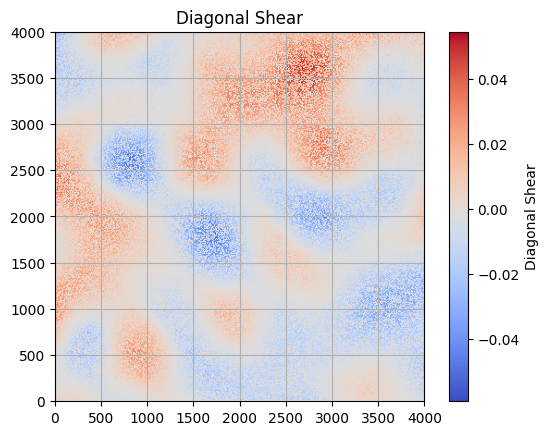

X:  tensor(3900.0500, dtype=torch.float64) tensor(7899.9944, dtype=torch.float64) Y:  tensor(3900.0501, dtype=torch.float64) tensor(7899.9410, dtype=torch.float64)


X:  tensor(7900.0038, dtype=torch.float64) tensor(11899.9880, dtype=torch.float64) Y:  tensor(3900.0032, dtype=torch.float64) tensor(7899.9406, dtype=torch.float64)


In [19]:
# scale is 10 pixels : 1 point on graph (as defined below)
grid_size = (400, 400)  # Define the size of the grid
original_size = (4000, 4000)
shear_type = "Diagonal Shear"
for idx in range(10): #98 patches in total, this is just the first 10
    plot_single_shear_map(idx, grid_size, original_size, shear_type)

In [25]:
# accumulator
# rows = 400
# cols = 400
# depth = 0

# vals = [[[None for _ in range(depth)] for _ in range(cols)] for _ in range(rows)]
# print(vals[0[0]])